# CITY SCHOOLS ANALYSIS

In [139]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup
from config import geoapify_key
from config import gmaps_key
import glob
import os
import matplotlib.pyplot as plt
import time
from scipy.stats import linregress
from scipy import stats   
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
# Display preferences
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.max_columns=300
# Increase the resolution of the figures
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

### Extract Data

In [144]:
# Return a list of all files
files = os.path.join(
    "/Users/chadbarlow/GoogleDrive/gt/hw/dunbars-number/chad/resources/data/state",
    "state*.csv")
files_list = glob.glob(files)
# Verify that all files contain identical columns and concat files
cols = [pd.read_csv(abs_path, nrows=0).columns for abs_path in files_list]
cols_identical = [all(cols[0] == colx) for colx in cols[1:]]
if all(cols_identical):
    source_df = pd.concat(map(pd.read_csv, files_list), ignore_index=True)
else:
    print("Columns are not equivalent")
source_df.head()

ValueError: No objects to concatenate

### Clean Data

In [72]:
# Check for duplicate rows. True denotes duplicates
print("Duplicated rows must be resolved") if all(source_df.duplicated()) else print("No duplicated rows.")
# Check that all records have exactly 1 instance per year/grade/test
print("All records have exactly 1 instance of the school>year>grade>test subgroup.") if all(source_df.groupby(["School Code","Test Year", "Grade","Test ID"]).count().iloc[:,0]) else print("Record/s contain duplicate subgroups")
# Check that only 2 test types are present
print("Testing categories are consistent.") if len(source_df["Test ID"].unique()) == 2 else print ("Testing categories are inconsistent.")
# Filter schools in districts of interest
LA_DISTRICT_CODE = 64733
LT_DISTRICT_CODE = 61903
SD_DISTRICT_CODE = 68338
df = source_df[
    source_df["District Code"].isin(
        [LA_DISTRICT_CODE, LT_DISTRICT_CODE, SD_DISTRICT_CODE])]
# Drop rows missing a School Code
df = df[df["School Code"] != 0]
# Drop rows that contain "*" in the PSE column
df = df[df["Percentage Standard Exceeded"].str.contains("\*") == False]
# Normalize school code syntax
df["County Code"] = df["County Code"].map("{:0>2}".format)
df["District Code"] = df["District Code"].map("{:0>5}".format)
df["School Code"] = df["School Code"].map("{:0>7}".format)
# Add new columns
data = (
    df["County Code"].map(str)
    + df["District Code"].map(str)
    + df["School Code"].map(str))
df.insert(4, "cds_code", data)
# Drop unecessary columns
df = df.iloc[:, :21]
df.drop([
        "Test Type",
        "Filler",
        "Students Tested",
        "Total Tested at Reporting Level",
        "Total Tested with Scores at Reporting Level",
        "Students Enrolled",
        "Mean Scale Score"],
    inplace=True,
    axis=1)
df.dropna(inplace=True)
# Initialize new columns
df["school_name"] = ""
df["charter"] = ""
df["magnet"] = ""
df["address"] = ""
df["latitude"] = ""
df["longitude"] = ""
df["website"] = ""
df["error_log"] = ""
clean_df = df.reset_index(drop=True)
clean_df.to_csv("/Users/chadbarlow/Desktop/clean_df.csv")
clean_df

No duplicated rows.
All records have exactly 1 instance of the school>year>grade>test subgroup.
Testing categories are consistent.


County Code District Code School Code        cds_code  Test Year  \
0              09         61903     0110155  09619030110155       2018   
1              09         61903     0110155  09619030110155       2018   
2              09         61903     0110155  09619030110155       2018   
3              09         61903     0110155  09619030110155       2018   
4              09         61903     0110155  09619030110155       2018   
...           ...           ...         ...             ...        ...   
56459          37         68338     6120935  37683386120935       2016   
56460          37         68338     6120935  37683386120935       2016   
56461          37         68338     6120935  37683386120935       2016   
56462          37         68338     6120935  37683386120935       2016   
56463          37         68338     6120935  37683386120935       2016   

       Student Group ID  Grade  Test ID Percentage Standard Exceeded  \
0                     1      3        2                        20.31   
1                     1      3        1                        42.19   
2                     1      4        1                        35.59   
3                     1      4        2                        28.81   
4                     1      5        2                        15.15   
...                 ...    ...      ...                          ...   
56459                 1      4        1                           15   
56460                 1      5        1                           33   
56461                 1      5        2                           39   
56462                 1     13        2                           25   
56463                 1     13        1                           23   

      Percentage Standard Met Percentage Standard Met and Above  \
0                       40.63                             60.94   
1                       26.56                             68.75   
2                       30.51                              66.1   
3                       40.68                             69.49   
4                       25.76                             40.91   
...                       ...                               ...   
56459                      26                                42   
56460                      36                                69   
56461                      19                                58   
56462                      32                                57   
56463                      30                                53   

      Percentage Standard Nearly Met Percentage Standard Not Met  \
0                                 25                       14.06   
1                              21.88                        9.38   
2                              15.25                       18.64   
3                              20.34                       10.17   
4                              48.48                       10.61   
...                              ...                         ...   
56459                             35                          24   
56460                             17                          14   
56461                             31                          12   
56462                             31                          13   
56463                             26                          20   

      Students with Scores school_name charter magnet latitude longitude  \
0                       64                                                 
1                       64                                                 
2                       59                                                 
3                       59                                                 
4                       66                                                 
...                    ...         ...     ...    ...      ...       ...   
56459                  118                                                 
56460                 

### Load Missing Data

In [74]:
# Scrape HTML 
def get_school_info(df):
    # Sort
    df.sort_values(["cds_code"], inplace=True)
    # Initialize empty list to keep track of schools that have been checked
    checked = []
    count = 0
    # Iterate through each row in the dataframe
    for index, row in df.iterrows():
        # Concatenate full CDS codes
        cds_code = str(row["cds_code"])
        # Proceed if CDS is unique
        if cds_code not in checked:
            # Send GET request to school directory website
            url = f"https://www.cde.ca.gov/schooldirectory/details?cdscode={cds_code}"
            df.at[index, "website"] = url
            response = requests.get(url)
            # Use BeautifulSoup to parse the HTML of the website
            soup = BeautifulSoup(response.text, "html.parser")
            # Digest the soup
            try:
                # Extract school information from website
                name = soup.select("h2")[0].get_text().strip()
                address = soup.select(".small div .div")[0].get_text().replace("  ", "").strip()
                charter = soup.select("tr:nth-child(19) td")[0].get_text().strip(),
                magnet = soup.select("tr:nth-child(20) td")[0].get_text().strip(),
                # Log the search results
                print(f"{count}: {name}")
                # Store school name in df
                try:
                    df.at[index, "school_name"] = name
                # Record school name error
                except Exception as e:
                    df.at[index, "school_name"] = f"school name data error: {e}"
                    print(f"school name data error: {e}")
                try:
                    df.at[index, "address"] = address
                # Record school name error
                except Exception as e:
                    df.at[index, "address"] = f"address data error: {e}"
                    print(f"address data error: {e}")
                # Store charter in df
                try:
                    df.at[index, "charter"] = charter
                # Record charter error
                except Exception as e:
                    df.at[index, "charter"] = f"charter data error: {e}"
                    print(f"charter data error: {e}")
                # Store magnet in df
                try:
                    df.at[index, "magnet"] = magnet
                # Record magnet error
                except Exception as e:
                    df.at[index, "magnet"] = f"magnet data error: {e}"
                    print(f"magnet data error: {e}")
                # Get latitude and longitude from geoapify API and store result in df
                try:
                    target_url = f"https://api.geoapify.com/v1/geocode/search?text={address}&format=json&apiKey={geoapify_key}"
                    geo_data = requests.get(target_url).json()
                    df.at[index, "latitude"] = geo_data["results"][0]["lat"]
                    df.at[index, "longitude"] = geo_data["results"][0]["lon"]
                # Record latitude and longitude error
                except Exception as e:
                    df.at[index, "latitude"] = f"lat lon data error: {e}"
                    print(f"lat lon data error: {e}")
            # Record website response error
            except Exception as e:
                df.at[index, "error_log"] = f"website response error: {e}"
                print(f"website response error: {e}")
            # Record checked school
            checked.append(cds_code)
            count += 1
            print(url)
    return df
# Call get_school_info and pass city_df as argument, save over original city_df
master_df = get_school_info(clean_df)
# Copy common features across matching records
columns_to_copy = [
    "school_name",
    "street_address",
    "latitude",
    "longitude",
    "google_maps_url"]
for col in columns_to_copy:
    master_df[col] = master_df.groupby("cds_code")[col].transform("first")
# Save to disk

# Results

master_df.to_csv("/Users/chadbarlow/Desktop/master_df.csv")


# Results

0: Lake Tahoe Environmental Science Magnet
https://www.cde.ca.gov/schooldirectory/details?cdscode=09619030110155
1: Elevated Digital Learning Academy
https://www.cde.ca.gov/schooldirectory/details?cdscode=09619030140459
2: Mt. Tallac High
https://www.cde.ca.gov/schooldirectory/details?cdscode=09619030930040
3: South Tahoe High
https://www.cde.ca.gov/schooldirectory/details?cdscode=09619030937805
4: Bijou Community
https://www.cde.ca.gov/schooldirectory/details?cdscode=09619036005540
5: South Tahoe Middle
https://www.cde.ca.gov/schooldirectory/details?cdscode=09619036005565
6: Tahoe Valley Elementary
https://www.cde.ca.gov/schooldirectory/details?cdscode=09619036005573
7: Sierra House Elementary
https://www.cde.ca.gov/schooldirectory/details?cdscode=09619036095301
8: N.E.W. Academy of Science and Arts
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330100289
9: Stella Middle Charter Academy
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330100669
10: High Tech L

https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330111500
82: Alliance Jack H. Skirball Middle
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330111518
83: Animo Ralph Bunche Charter High
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330111575
84: Animo Jackie Robinson High
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330111583
85: Animo Watts College Preparatory Academy
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330111625
86: Alliance Ouchi-O'Donovan 6-12 Complex
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330111641
87: Alliance Marc & Eva Stern Math and Science
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330111658
88: George De La Torre Jr. Elementary
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330111955
89: Frank del Olmo Elementary
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330111971
90: Charles H. Kim Elementary
https://www.cde.ca.gov/schooldirect

158: Equitas Academy Charter
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330119982
159: KIPP Endeavor College Preparatory Charter
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330120014
160: Valor Academy Middle
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330120022
161: Alliance College-Ready Middle Academy 4
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330120030
162: Alliance College-Ready Middle Academy 5
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330120048
163: PUC Nueva Esperanza Charter Academy
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330120055
164: New Designs Charter School-Watts
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330120071
165: Academia Moderna
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330120097
166: Daniel Pearl Journalism & Communications Magnet
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330120360
167: Aspire Titan Academ

https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330124370
235: Cesar E. Chavez Learning Academies-Social Justice Humanitas Academy
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330124388
236: Cesar E. Chavez Learning Academies-Academy of Scientific Exploration (ASE)
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330124396
237: Cesar E. Chavez Learning Academies-Technology Preparatory Academy
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330124404
238: Sotomayor Arts and Sciences Magnet
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330124412
239: School of History and Dramatic Arts at Sonia Sotomayor Learning Academies
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330124420
240: Dr. Julian Nava Learning Academies-School of Arts and Culture
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330124446
241: Dr. Julian Nava Learning Academy
https://www.cde.ca.gov/schooldirectory/details?cdscode=1964733

304: Studio
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330127829
305: Executive Preparatory Academy of Finance
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330127852
306: Pathways Community
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330127878
307: City Language Immersion Charter
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330127886
308: Valor Academy High
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330127894
309: Camino Nuevo High #2
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330127910
310: PREPA TEC - Los Angeles
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330127936
311: Metro Charter
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330127977
312: Ingenium Charter Middle
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330127985
313: Alliance Virgil Roberts Leadership Academy
https://www.cde.ca.gov/schooldirectory/details?cdscode=19647330128009
websit

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [6]:
# Google Maps API fetch distance and travel duration
LA_HOUSE_ORIGIN = ("LA", 34.083820, -118.281479)
LT_HOUSE_ORIGIN = ("LT", 38.940151, -119.946182)
SD_HOUSE_ORIGIN = ("SD", 32.807720, -117.125839)
def calculate_distance_and_time(dataframe):
    checked = []
    count = 0
    for index, row in dataframe.iterrows():
        cds_code = str(row["cds_code"])
        if cds_code not in checked:
            count += 1
            school_name = row["school_name"]
            print(f"{count}: {school_name}")
            county_code = str(row["County Code"])
            try:
                if county_code == "19":
                    origin = LA_HOUSE_ORIGIN[1:]
                elif county_code == "9":
                    origin = LT_HOUSE_ORIGIN[1:]
                elif county_code == "37":
                    origin = SD_HOUSE_ORIGIN[1:]
                destination = (row["latitude"], row["longitude"])
                url = f"https://maps.googleapis.com/maps/api/distancematrix/json?departure_time=1707145200&traffic_model=pessimistic&units=imperial&origins={origin[0]},{origin[1]}&destinations={destination[0]},{destination[1]}&key={gmaps_key}"
                result = requests.get(url).json()
                print(url)
                distance = result["rows"][0]["elements"][0]["distance"]["value"] / 1609.344
                duration = result["rows"][0]["elements"][0]["duration_in_traffic"]["value"] / 60
                dataframe.at[index, "distance"] = distance
                dataframe.at[index, "duration"] = duration
            except Exception as e:
                print(f"{e}")
            checked.append(cds_code)
    return dataframe
# Read from disk
master_df = pd.read_csv("/Users/chadbarlow/Desktop/master_df.csv")
master_df = master_df.iloc[:, 1:-2].dropna()
master_df["distance"] = ""
master_df["duration"] = ""
master_df = calculate_distance_and_time(master_df)
columns_to_copy = ["distance", "duration"]
for col in columns_to_copy:
    master_df[col] = master_df.groupby("cds_code")[col].transform("first")
# Save to disk
master_df.to_csv(f"/Users/chadbarlow/Desktop/master_2.csv")
master_df

1: Lake Tahoe Environmental Science Magnet



KeyboardInterrupt: 

### Transform Data

In [96]:
# Read from disk
master_df = pd.read_csv("/Users/chadbarlow/Desktop/master_2.csv")
master_df
cities = {9: "Lake Tahoe", 19: "Los Angeles", 37: "San Diego"}
master_df = master_df.replace({"County Code": cities})
master_df.drop([
        "Unnamed: 0",
        "District Code",
        "School Code",
        "Student Group ID",
        "Percentage Standard Exceeded",
        "Percentage Standard Met",
        "Percentage Standard Nearly Met",
        "Percentage Standard Not Met",
        "Students with Scores",
        "street_address",
        "google_maps_url",],
    inplace=True,
    axis=1)
master_df = master_df.rename(columns = {"County Code":"City"})
master_df

# Create city dataframes
la_df = master_df.groupby(["City"]).get_group("Los Angeles")
lt_df = master_df.groupby(["City"]).get_group("Lake Tahoe")
sd_df = master_df.groupby(["City"]).get_group("San Diego")
laa_df = (
    la_df
    .groupby(["school_name"])
    .mean()
    .reset_index())
sda_df = (
    sd_df
    .groupby(["school_name"])
    .mean()
    .reset_index())
lta_df = (
    lt_df
    .groupby(["school_name"])
    .mean()
    .reset_index())
laab_df = laa_df.round(-1).groupby(["Percentage Standard Met and Above"]).count().cds_code
ltab_df = lta_df.round(-1).groupby(["Percentage Standard Met and Above"]).count().cds_code
sdab_df = sda_df.round(-1).groupby(["Percentage Standard Met and Above"]).count().cds_code
ltab_df = pd.DataFrame.from_dict({0.0: [0],
          10.0: [5],
          20.0: [0],
          30.0: [10],
          40.0: [20],
          50.0: [0],
          60.0: [0],
          70.0: [5],
          80.0: [0],
          90.0: [0]})
master_df

City        cds_code  Test Year  Grade  Test ID  \
0      Lake Tahoe   9619030110155       2018      3        2   
1      Lake Tahoe   9619030110155       2017     13        1   
2      Lake Tahoe   9619030110155       2015      3        1   
3      Lake Tahoe   9619030110155       2019     13        2   
4      Lake Tahoe   9619030110155       2019      5        2   
...           ...             ...        ...    ...      ...   
55645   San Diego  37683386120935       2019      3        2   
55646   San Diego  37683386120935       2019      4        2   
55647   San Diego  37683386120935       2019      5        2   
55648   San Diego  37683387093115       2015     13        2   
55649   San Diego  37683387093115       2015     13        1   

       Percentage Standard Met and Above  \
0                                  60.94   
1                                  77.08   
2                                  84.00   
3                                  55.85   
4                                  46.67   
...                                  ...   
55645                              68.89   
55646                              57.25   
55647                              50.82   
55648                              11.00   
55649                              15.00   

                                      school_name   latitude   longitude  \
0         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
1         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
2         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
3         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
4         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
...                                           ...        ...         ...   
55645  Albert Einstein Academy Charter Elementary  32.720148 -117.128967   
55646  Albert Einstein Academy Charter Elementary  32.720148 -117.128967   
55647  Albert Einstein Academy Charter Elementary  32.720148 -117.128967   
55648       San Diego Center for Children Academy  32.799803 -117.166722   
55649       San Diego Center for Children Academy  32.799803 -117.166722   

       distance   duration  
0      3.390823  10.233333  
1      3.390823  10.233333  
2      3.390823  10.233333  
3      3.390823  10.233333  
4      3.390823  10.233333  
...         ...        ...  
55645  8.237518  15.650000  
55646  8.237518  15.650000  
55647  8.237518  15.650000  
55648  3.306937  11.800000  
55649  3.306937  11.800000  

[55650 rows x 11 columns]

### Bar charts and histograms

In [63]:
ot_df = master_df.groupby(["City","Test Year"])["Percentage Standard Met and Above"].mean().reset_index()
ot_df
# ot_df["Test Year"].unique()

City  Test Year  Percentage Standard Met and Above
0    Lake Tahoe       2015                          37.250000
1    Lake Tahoe       2016                          39.104167
2    Lake Tahoe       2017                          40.140417
3    Lake Tahoe       2018                          37.650833
4    Lake Tahoe       2019                          37.575417
5    Lake Tahoe       2022                          36.637963
6   Los Angeles       2015                          28.975997
7   Los Angeles       2016                          33.917466
8   Los Angeles       2017                          34.751322
9   Los Angeles       2018                          37.019046
10  Los Angeles       2019                          38.224904
11  Los Angeles       2021                          32.946356
12  Los Angeles       2022                          34.045777
13    San Diego       2015                          40.888383
14    San Diego       2016                          45.490395
15    San Diego       2017                          46.257890
16    San Diego       2018                          47.932817
17    San Diego       2019                          49.195054
18    San Diego       2021                          41.442753
19    San Diego       2022                          43.819741

<AxesSubplot:xlabel='Test Year', ylabel='Percentage Standard Met and Above'>

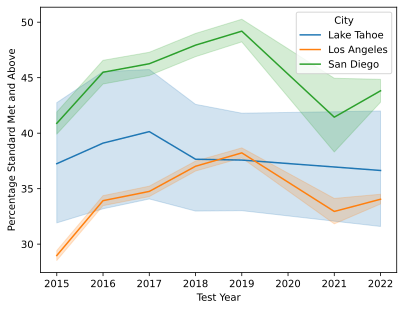

In [71]:
sns.lineplot(data=master_df,x="Test Year",y="Percentage Standard Met and Above",hue="City")

### plt testing

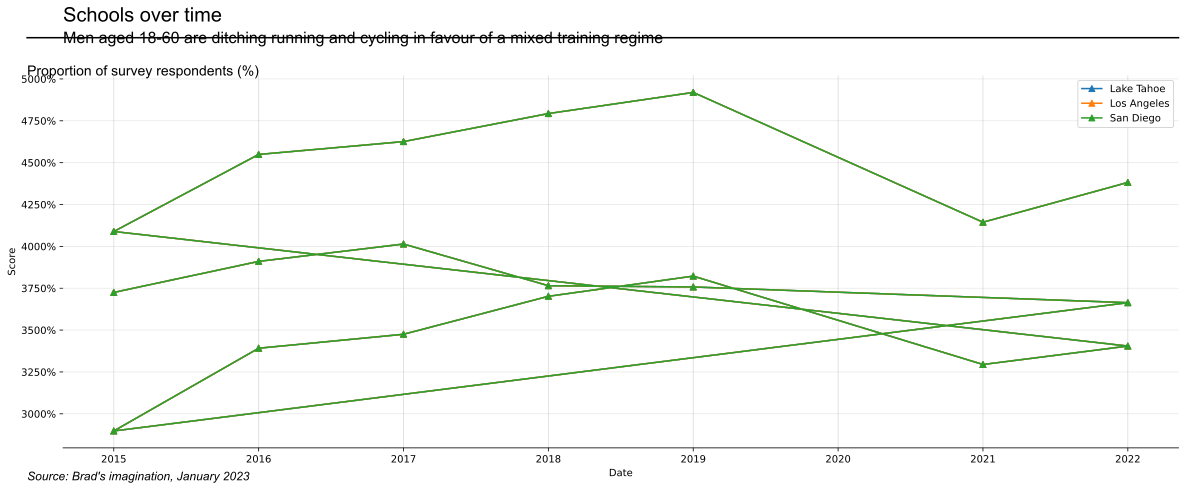

In [58]:
# Over time


# plot
fig,ax = plt.subplots(figsize = (20,7.5))

# informative title + subtitle
title = "Schools over time"
subtitle = 'Men aged 18-60 are ditching running and cycling in favour of a mixed training regime'

# add title + subtitle to plot
plt.text(
    x = 0.125,y = 0.90,s = title,fontname = 'Arial',
    fontsize = 20,ha='left',transform = fig.transFigure
)
plt.text(
    x = 0.125,y = 0.86,s = subtitle,fontname = 'Arial',
    fontsize = 16,ha = 'left',transform = fig.transFigure
)

# lines
for city in ot_df["City"].unique():
    plt.plot(ot_df["Test Year"],ot_df["Percentage Standard Met and Above"],marker = '^',label = f'{city}')

# format y-axis
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1,decimals = 0))

# axis labels
plt.ylabel('Score')
plt.xlabel('Date')

# misc - grid and legend
plt.grid(axis = 'both',alpha = 0.45)
plt.legend(loc = 'best',ncol = 1)

# fiddle with space above chart
plt.subplots_adjust(top=0.8, wspace=0.3)

# annotate
# plt.annotate(
#     text = 'Running',
#     xy = (pd.to_datetime('01-01-2022'),df['Run'][-1]),
#     textcoords = 'offset points',
#     xytext = (5,-4),fontname = 'Arial',fontsize = 13,color = 'tab:blue'
# )

# grid lines
# keep only toned down vertical lines
plt.grid(axis = 'y',alpha = 0.3)

# turn off spines
plt.gca().spines[['left','right', 'top']].set_visible(False)

# line between titles and chart
plt.gca().plot(
    [0.1, .9], # x co-ords
    [.87, .87], # y co-ords
    transform = fig.transFigure,
    clip_on = False,
    color = 'k',
    linewidth = 1.5
)

# axis description
description = 'Proportion of survey respondents (%)'
plt.text(
    x = 0.1,
    y = 0.8,
    s = description,
    fontname = 'Arial',
    fontsize = 14,
    ha='left',
    transform = fig.transFigure
)

# foot note
footnote = "Source: Brad's imagination, January 2023"
plt.text(
    x = 0.1,
    y = 0.05,
    s = footnote,
    fontname = 'Arial',
    fontstyle = 'italic',
    fontsize = 12,
    ha = 'left',
    transform = fig.transFigure
)

plt.show()



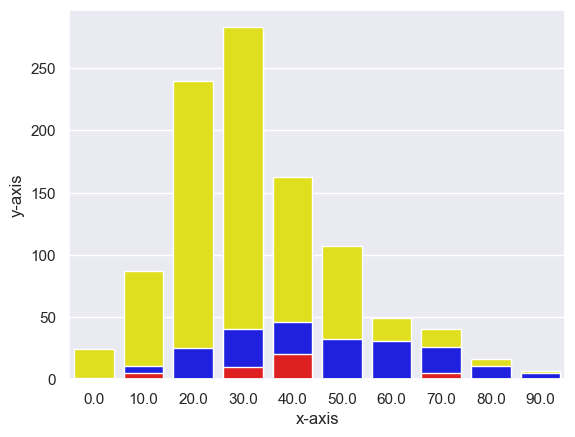

In [738]:
# Create plots
ax = plt.subplots()
# plotting columns
ax = sns.barplot(x=laab_df.index, y=laab_df.values, color="yellow")
ax = sns.barplot(x=sdab_df.index, y=sdab_df.values, color="blue")
ax = sns.barplot(x=ltab_df.columns, y=ltab_df.iloc[0, :], color="red")
# renaming the axes
ax.set(xlabel="x-axis", ylabel="y-axis")
# visualizing illustration
plt.show()

In [3]:
"""
NOTE: KDE plots have many advantages. Important features of the 
data are easy to discern (central tendency, bimodality, skew), 
and they afford easy comparisons between subsets.

"""
snsplot_df = master_df
b = sns.displot(
    snsplot_df,
    x="Percentage Standard Met and Above",
    hue="County Code",
    kind="kde",
    palette=["r", "y", "b"],
    common_norm=False,
    #bw_adjust=1,
    fill=True,
    facet_kws={"legend_out": True},
    #stat="density"
)  # kde=True, fill=True, element="step",stat="density",
plt.xlim(0, 100)
new_title = ""
b._legend.set_title(new_title)
# replace labels
new_labels = ["Lake Tahoe", "Los Angeles", "San Diego"]
for t, l in zip(b._legend.texts, new_labels):
    t.set_text(l)
b.set(xticks=np.arange(0, 110, 10))

NameError: name 'master_df' is not defined

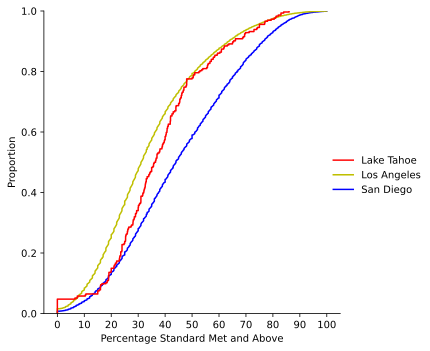

In [16]:
c = sns.displot(
    snsplot_df,
    x="Percentage Standard Met and Above",
    hue="County Code",
    palette=["r", "y", "b"],
    kind="ecdf",
    facet_kws={"legend_out": True},
)
new_title = ""
c._legend.set_title(new_title)
new_labels = ["Lake Tahoe", "Los Angeles", "San Diego"]
for t, l in zip(c._legend.texts, new_labels):
    t.set_text(l)
c.set(xticks=np.arange(0, 110, 10))
#plt.title("LOS ANGELES\nStudents Passing (%) vs. Commute (min)")

### Scatter plots: School Quality vs. Commute

The correlation is 0.17.


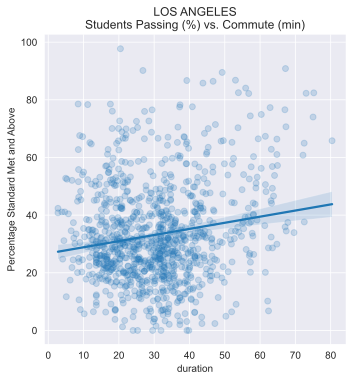

In [76]:
x = "duration"
y = "Percentage Standard Met and Above"
sns.lmplot(x=x, y=y, data=laa_df, fit_reg=True, scatter_kws={"alpha": 0.2})
plt.title("LOS ANGELES\nStudents Passing (%) vs. Commute (min)")
print(f"The correlation is {round(laa_df.corr().loc[x, y], 2)}.")

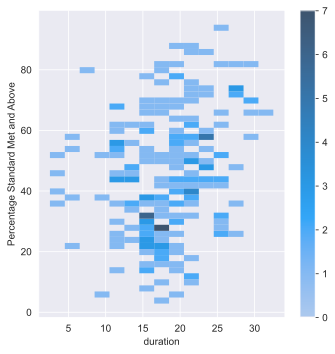

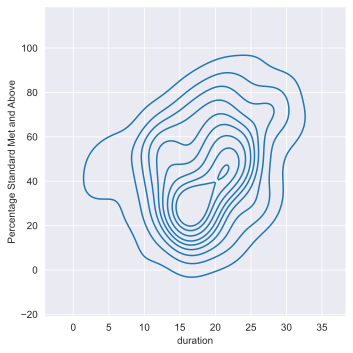

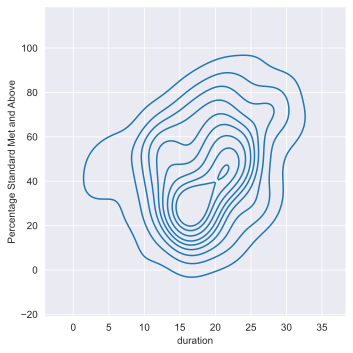

In [77]:
sns.displot(sda_df, x=x, y=y, binwidth=(2, 2), cbar=True)
sns.displot(sda_df, x=x, y=y, kind="kde")
sns.displot(sda_df, x=x, y=y, kind="kde")

The correlation is -0.32.


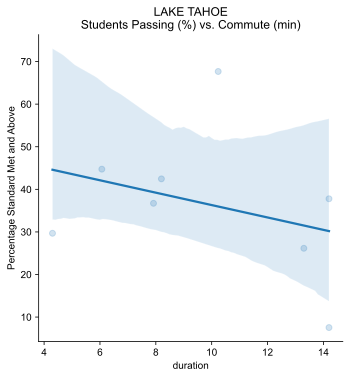

In [75]:
sns.lmplot(x=x, y=y, data=lta_df, fit_reg=True, scatter_kws={"alpha": 0.2})
sns.set_style("darkgrid")
plt.title("LAKE TAHOE\nStudents Passing (%) vs. Commute (min)")
print(f"The correlation is {round(lta_df.corr().loc[x, y], 2)}.")

The correlation is 0.28.


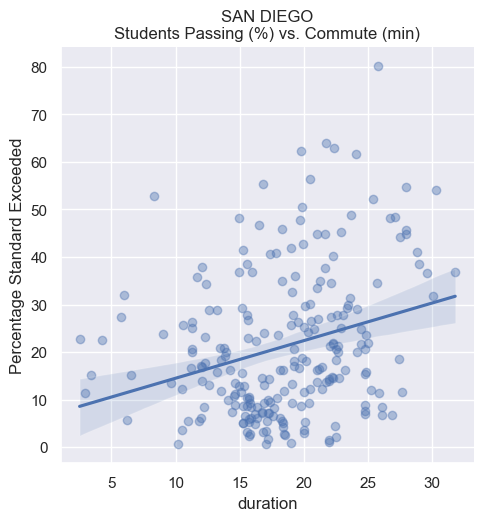

In [723]:
sns.lmplot(x=x, y=y, data=sda_df, fit_reg=True, scatter_kws={"alpha": 0.4})
sns.set_style("darkgrid")
plt.title("SAN DIEGO\nStudents Passing (%) vs. Commute (min)")
print(f"The correlation is {round(sda_df.corr().loc[x, y], 2)}.")

### Bonus

In [19]:
laa_df.groupby(
    pd.cut(
        laa_df["Percentage Standard Met and Above"],
        np.percentile(
            laa_df["Percentage Standard Met and Above"],
            [0,50],),
        include_lowest=True,)).agg({
        "Percentage Standard Met and Above": ["count", "mean"],
        "duration": ["mean"],})

Percentage Standard Met and Above  \
                                                              count   
Percentage Standard Met and Above                                     
(-0.001, 30.639]                                                509   

                                               duration  
                                        mean       mean  
Percentage Standard Met and Above                        
(-0.001, 30.639]                   20.341301  28.833039

In [112]:
scatter_df = master_df.groupby(["school_name", "Test ID"]).agg(
    {
     "City": "first", 
     "Percentage Standard Met and Above": "first",
     "duration": "mean"
    }
).reset_index()
scatter_df

school_name  Test ID         City  \
0                            ALBA        1    San Diego   
1                            ALBA        2    San Diego   
2                    APEX Academy        1  Los Angeles   
3                    APEX Academy        2  Los Angeles   
4     Abraham Lincoln Senior High        1  Los Angeles   
...                           ...      ...          ...   
2497       Zane Grey Continuation        2  Los Angeles   
2498                e3 Civic High        1    San Diego   
2499                e3 Civic High        2    San Diego   
2500        iHigh Virtual Academy        1    San Diego   
2501        iHigh Virtual Academy        2    San Diego   

      Percentage Standard Met and Above   duration  
0                                  0.00  17.016667  
1                                  8.00  17.016667  
2                                 14.04   8.716667  
3                                  6.90   8.716667  
4                                 40.00  19.166667  
...                                 ...        ...  
2497                               0.00  33.100000  
2498                              52.38  20.483333  
2499                              29.73  20.483333  
2500                              84.62  19.000000  
2501                              83.00  19.000000  

[2502 rows x 5 columns]

<AxesSubplot:xlabel='duration', ylabel='Percentage Standard Met and Above'>

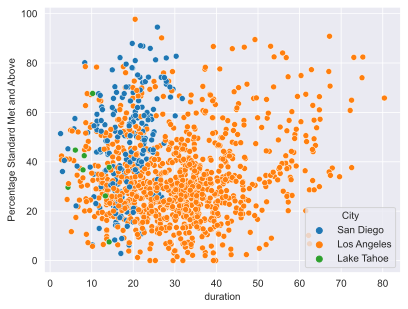

In [88]:
sns.scatterplot(data=scatter_df,x="duration",y="Percentage Standard Met and Above",hue="City")

<AxesSubplot:xlabel='Percentage Standard Met and Above', ylabel='Count'>

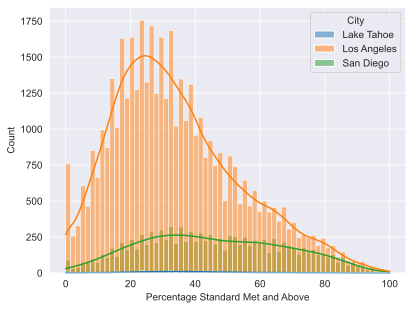

In [108]:
sns.histplot(x="Percentage Standard Met and Above",data=master_df,hue="City",kde=True)

In [115]:
boxplot_df = master_df.groupby(["school_name"]).agg(
    {
     "City": "first", 
     "Percentage Standard Met and Above": "mean",
     "duration": "mean"
    }
).reset_index()
boxplot_df

school_name         City  \
0                                                  ALBA    San Diego   
1                                          APEX Academy  Los Angeles   
2                           Abraham Lincoln Senior High  Los Angeles   
3                                      Academia Moderna  Los Angeles   
4     Academies of Education and Empowerment at Cars...  Los Angeles   
...                                                 ...          ...   
1247                      Youth Opportunities Unlimited  Los Angeles   
1248                                Zamorano Elementary    San Diego   
1249                             Zane Grey Continuation  Los Angeles   
1250                                      e3 Civic High    San Diego   
1251                              iHigh Virtual Academy    San Diego   

      Percentage Standard Met and Above   duration  
0                              2.865500  17.016667  
1                             10.631667   8.716667  
2                             42.532143  19.166667  
3                             23.480625  39.866667  
4                             34.411429  44.383333  
...                                 ...        ...  
1247                           1.579167  30.533333  
1248                          48.792708  22.666667  
1249                           3.312500  33.100000  
1250                          36.745000  20.483333  
1251                          54.564615  19.000000  

[1252 rows x 4 columns]

<AxesSubplot:xlabel='City', ylabel='Percentage Standard Met and Above'>

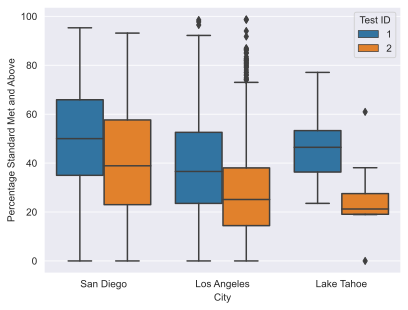

In [117]:
sns.boxplot(x="City",y="Percentage Standard Met and Above",data=scatter_df,hue="Test ID")

<AxesSubplot:xlabel='City', ylabel='Percentage Standard Met and Above'>

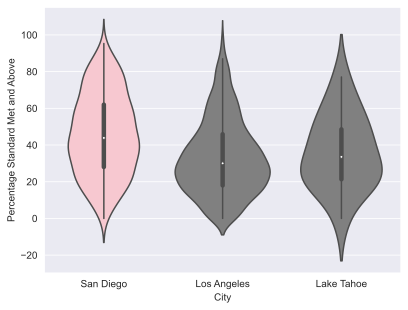

In [123]:
# creating a dictionary with one specific color per group:
custom_palette = {"San Diego": "pink", "Los Angeles": "grey", "Lake Tahoe": "grey"}

sns.violinplot(x="City",y="Percentage Standard Met and Above",data=scatter_df,palette=custom_palette)

/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

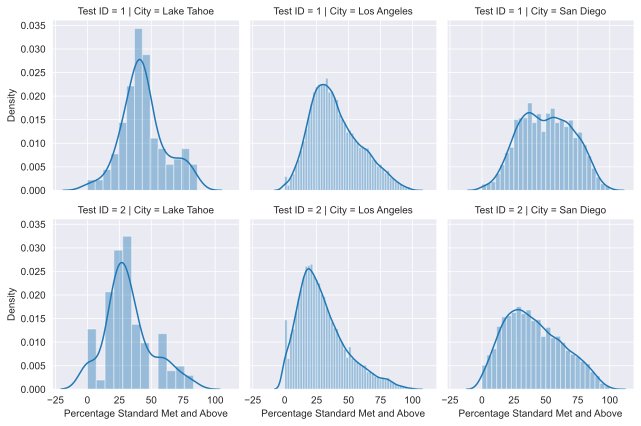

In [126]:
sns.FacetGrid(master_df,col="City",row="Test ID").map(sns.distplot,"Percentage Standard Met and Above")

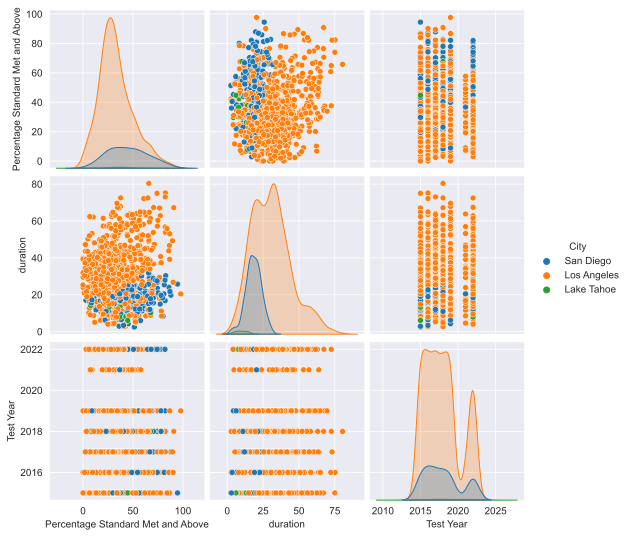

In [131]:
pairplot_df = master_df.groupby(["school_name"]).agg(
    {
     "City": "first", 
     "Percentage Standard Met and Above": "mean",
     "duration": "mean",
        "Test Year": "first"
    }
).reset_index()
sns.pairplot(pairplot_df,hue="City")

In [135]:


city_codes = {"Lake Tahoe": 2, "Los Angeles": 1, "San Diego": 3}
heatmap_df = master_df.replace({"City": city_codes})
heatmap_df

City        cds_code  Test Year  Grade  Test ID  \
0         2   9619030110155       2018      3        2   
1         2   9619030110155       2017     13        1   
2         2   9619030110155       2015      3        1   
3         2   9619030110155       2019     13        2   
4         2   9619030110155       2019      5        2   
...     ...             ...        ...    ...      ...   
55645     3  37683386120935       2019      3        2   
55646     3  37683386120935       2019      4        2   
55647     3  37683386120935       2019      5        2   
55648     3  37683387093115       2015     13        2   
55649     3  37683387093115       2015     13        1   

       Percentage Standard Met and Above  \
0                                  60.94   
1                                  77.08   
2                                  84.00   
3                                  55.85   
4                                  46.67   
...                                  ...   
55645                              68.89   
55646                              57.25   
55647                              50.82   
55648                              11.00   
55649                              15.00   

                                      school_name   latitude   longitude  \
0         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
1         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
2         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
3         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
4         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
...                                           ...        ...         ...   
55645  Albert Einstein Academy Charter Elementary  32.720148 -117.128967   
55646  Albert Einstein Academy Charter Elementary  32.720148 -117.128967   
55647  Albert Einstein Academy Charter Elementary  32.720148 -117.128967   
55648       San Diego Center for Children Academy  32.799803 -117.166722   
55649       San Diego Center for Children Academy  32.799803 -117.166722   

       distance   duration  
0      3.390823  10.233333  
1      3.390823  10.233333  
2      3.390823  10.233333  
3      3.390823  10.233333  
4      3.390823  10.233333  
...         ...        ...  
55645  8.237518  15.650000  
55646  8.237518  15.650000  
55647  8.237518  15.650000  
55648  3.306937  11.800000  
55649  3.306937  11.800000  

[55650 rows x 11 columns]

<AxesSubplot:>

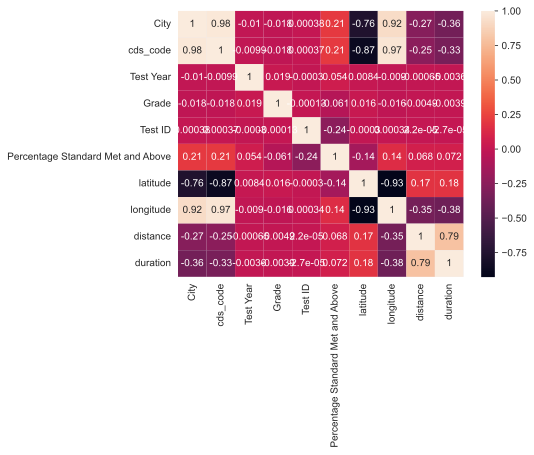

In [137]:
sns.heatmap(heatmap_df.corr(),annot=True)

In [133]:
master_df

City        cds_code  Test Year  Grade  Test ID  \
0      Lake Tahoe   9619030110155       2018      3        2   
1      Lake Tahoe   9619030110155       2017     13        1   
2      Lake Tahoe   9619030110155       2015      3        1   
3      Lake Tahoe   9619030110155       2019     13        2   
4      Lake Tahoe   9619030110155       2019      5        2   
...           ...             ...        ...    ...      ...   
55645   San Diego  37683386120935       2019      3        2   
55646   San Diego  37683386120935       2019      4        2   
55647   San Diego  37683386120935       2019      5        2   
55648   San Diego  37683387093115       2015     13        2   
55649   San Diego  37683387093115       2015     13        1   

       Percentage Standard Met and Above  \
0                                  60.94   
1                                  77.08   
2                                  84.00   
3                                  55.85   
4                                  46.67   
...                                  ...   
55645                              68.89   
55646                              57.25   
55647                              50.82   
55648                              11.00   
55649                              15.00   

                                      school_name   latitude   longitude  \
0         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
1         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
2         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
3         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
4         Lake Tahoe Environmental Science Magnet  38.933241 -119.984348   
...                                           ...        ...         ...   
55645  Albert Einstein Academy Charter Elementary  32.720148 -117.128967   
55646  Albert Einstein Academy Charter Elementary  32.720148 -117.128967   
55647  Albert Einstein Academy Charter Elementary  32.720148 -117.128967   
55648       San Diego Center for Children Academy  32.799803 -117.166722   
55649       San Diego Center for Children Academy  32.799803 -117.166722   

       distance   duration  
0      3.390823  10.233333  
1      3.390823  10.233333  
2      3.390823  10.233333  
3      3.390823  10.233333  
4      3.390823  10.233333  
...         ...        ...  
55645  8.237518  15.650000  
55646  8.237518  15.650000  
55647  8.237518  15.650000  
55648  3.306937  11.800000  
55649  3.306937  11.800000  

[55650 rows x 11 columns]